In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
import importlib
from mlfs.airquality import util
importlib.reload(util)
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [25]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
index = dict()
for i in range(1,6):
    location_str = secrets.get_secret(f"SENSOR_LOCATION_JSON_{i}").value
    location = json.loads(location_str)
    country=location['country']
    city=location['city']
    street=location['street']
    csv = location['csv']
    index[f'sensor_{i}'] = dict()
    index[f'sensor_{i}']['country'] = country
    index[f'sensor_{i}']['city'] = city
    index[f'sensor_{i}']['street'] = street
    index[f'sensor_{i}']['csv'] = csv

2025-11-17 17:29:43,744 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-17 17:29:43,756 INFO: Initializing external client
2025-11-17 17:29:43,764 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-17 17:29:45,231 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286306


In [26]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality_a',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather_a',
    version=1,
)

In [27]:
air = air_quality_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.22s) 


In [28]:
air[air['date'] == air['date'].max()]

,date,pm25,lagging1,lagging2,lagging3,country,city,street,url
3829,2025-11-17 00:00:00+00:00,0.15,0.22,0.2,0.4,sweden,Skönsmon,Björneborgsgatan,https://api.waqi.info/feed/A60889
4841,2025-11-17 00:00:00+00:00,0.00,0.10,0.2,0.1,sweden,Sundsvall,Korstavägen,https://api.waqi.info/feed/A351115
6310,2025-11-17 00:00:00+00:00,7.00,25.00,22.0,32.0,sweden,Sundsvall,Köpmangatan,https://api.waqi.info/feed/@10010
7624,2025-11-17 00:00:00+00:00,0.00,4.00,1.0,1.0,sweden,Örnsköldsvik,Hörnettvägen,https://api.waqi.info/feed/A105325
8572,2025-11-17 00:00:00+00:00,5.00,33.00,21.0,44.0,sweden,Sundsvall,Bergsgatan,https://api.waqi.info/feed/@13973


--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [29]:
# Select features for training data.
feature = dict()
selected_features = air_quality_fg.select(['pm25', 'date','lagging1','lagging2','lagging3','street']).join(weather_fg.select_features(), on=['street','city']) # Select rolling

2025-11-17 17:30:00,072 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_a` as features for the query. To include primary key and event time use `select_all`.


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [30]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv_a',
    description="weather features with air quality as the target a",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [31]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [32]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.58s) 


In [33]:
X_train

,date,lagging1,lagging2,lagging3,street,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2022-09-05 00:00:00+00:00,7.0,7.0,8.0,Bergsgatan,9.939500,0.0,10.440001,256.248474
1,2022-09-06 00:00:00+00:00,11.0,7.0,7.0,Bergsgatan,10.731166,0.0,12.261157,310.303436
2,2022-09-07 00:00:00+00:00,11.0,11.0,7.0,Bergsgatan,10.260333,0.0,10.390226,85.309387
3,2022-09-08 00:00:00+00:00,11.0,11.0,11.0,Bergsgatan,9.897832,0.0,7.636753,150.557800
4,2022-09-09 00:00:00+00:00,8.0,11.0,11.0,Bergsgatan,10.839500,0.0,11.183201,204.863663
...,...,...,...,...,...,...,...,...,...
8656,2025-04-26 00:00:00+00:00,0.0,0.0,0.0,Korstavägen,2.114500,0.2,14.168641,57.163864
8657,2025-04-27 00:00:00+00:00,0.0,0.0,0.0,Korstavägen,5.818666,0.0,8.557102,199.165527
8658,2025-04-28 00:00:00+00:00,0.0,0.0,0.0,Korstavägen,8.129083,2.0,21.066151,298.405701
8659,2025-04-29 00:00:00+00:00,0.0,0.0,0.0,Korstavägen,8.020749,3.0,27.268068,318.272614


In [34]:
y_train['street'] = X_train['street']
y_test['street'] = X_test['street']
y_train

,pm25,street
0,11.0,Bergsgatan
1,11.0,Bergsgatan
2,11.0,Bergsgatan
3,8.0,Bergsgatan
4,10.0,Bergsgatan
...,...,...
8656,0.0,Korstavägen
8657,0.0,Korstavägen
8658,0.0,Korstavägen
8659,0.0,Korstavägen


In [35]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [36]:
X_features

,lagging1,lagging2,lagging3,street,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,7.0,7.0,8.0,Bergsgatan,9.939500,0.0,10.440001,256.248474
1,11.0,7.0,7.0,Bergsgatan,10.731166,0.0,12.261157,310.303436
2,11.0,11.0,7.0,Bergsgatan,10.260333,0.0,10.390226,85.309387
3,11.0,11.0,11.0,Bergsgatan,9.897832,0.0,7.636753,150.557800
4,8.0,11.0,11.0,Bergsgatan,10.839500,0.0,11.183201,204.863663
...,...,...,...,...,...,...,...,...
8656,0.0,0.0,0.0,Korstavägen,2.114500,0.2,14.168641,57.163864
8657,0.0,0.0,0.0,Korstavägen,5.818666,0.0,8.557102,199.165527
8658,0.0,0.0,0.0,Korstavägen,8.129083,2.0,21.066151,298.405701
8659,0.0,0.0,0.0,Korstavägen,8.020749,3.0,27.268068,318.272614


In [37]:
X_dict = dict()
y_dict = dict()
for key in index.keys():
    X_dict[key] = dict()
    y_dict[key] = dict()
    X_dict[key]['X_features'] = X_features[X_features['street'] == index[key]['street']].drop(columns=['street'])
    X_dict[key]['X_test_features'] = X_test_features[X_test_features['street'] == index[key]['street']].drop(columns=['street'])
    # # X_dict[key]['X_features'].drop(columns=['street'])
    # X_dict[key]['X_test_features'].drop(columns=['street'])
    y_dict[key]['y_train'] = y_train[y_train['street'] == index[key]['street']].drop(columns=['street'])
    y_dict[key]['y_test'] = y_test[y_test['street'] == index[key]['street']].drop(columns=['street'])
    # y_dict[key]['y_train'].drop(columns=['street'])
    # y_dict[key]['y_test'].drop(columns=['street'])

In [38]:
X_dict['sensor_1']['X_features'].keys()

Index(['lagging1', 'lagging2', 'lagging3', 'temperature_2m_mean',
       'precipitation_sum', 'wind_speed_10m_max',
       'wind_direction_10m_dominant'],
      dtype='object')

The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [39]:
# Creating an instance of the XGBoost Regressor
model = dict()
for key in X_dict.keys():
    xgb_regressor = XGBRegressor()
    # Fitting the XGBoost Regressor to the training data
    xgb_regressor.fit(X_dict[key]['X_features'], y_dict[key]['y_train'])
    model[key] = xgb_regressor

In [40]:
model.keys()

dict_keys(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5'])

In [41]:
# Predicting target values on the test set
for key in model.keys():
    y_pred = model[key].predict(X_dict[key]['X_test_features'])
    y_dict[key]['y_pred'] = y_pred
    print(key)
    # Calculating Mean Squared Error (MSE) using sklearn
    mse = mean_squared_error(y_dict[key]['y_test'].iloc[:,0], y_pred)
    y_dict[key]['mse2'] = mse
    print("mse2:", mse)
    
    # Calculating R squared using sklearn
    r2 = r2_score(y_dict[key]['y_test'].iloc[:,0], y_pred)
    y_dict[key]['r2'] = r2
    print("R squared:", r2)

sensor_1
mse2: 24.212144085619194
R squared: 0.3390214047696277
sensor_2
mse2: 65.31722800818304
R squared: 0.5723644168061122
sensor_3
mse2: 0.09128076794258458
R squared: 0.5437813337409783
sensor_4
mse2: 0.7743682696657758
R squared: 0.5121677713868469
sensor_5
mse2: 78.94502792982527
R squared: 0.5018534398424291


In [42]:
df = dict()
for key in index.keys():
    df[key] = y_dict[key]['y_test']
    df[key]['predicted_pm25'] = y_dict[key]['y_pred']
    df[key]['date'] = X_test['date']
    df[key] = df[key].sort_values(by=['date'])

In [43]:
df['sensor_1']

,pm25,predicted_pm25,date
2631,14.0,9.986333,2025-05-01 00:00:00+00:00
2632,9.0,10.246799,2025-05-02 00:00:00+00:00
2633,1.0,12.105567,2025-05-03 00:00:00+00:00
2634,1.0,1.746734,2025-05-04 00:00:00+00:00
2635,0.0,2.738841,2025-05-05 00:00:00+00:00
...,...,...,...
2790,5.0,2.626564,2025-11-13 00:00:00+00:00
2791,1.0,6.197063,2025-11-14 00:00:00+00:00
2792,1.0,6.650398,2025-11-15 00:00:00+00:00
2793,4.0,2.467770,2025-11-16 00:00:00+00:00


In [44]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

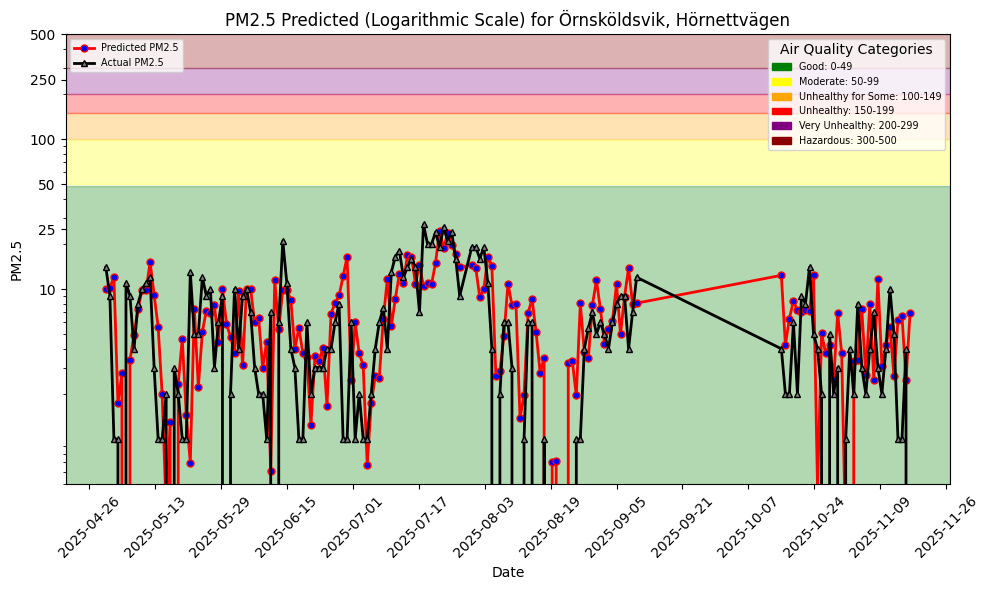

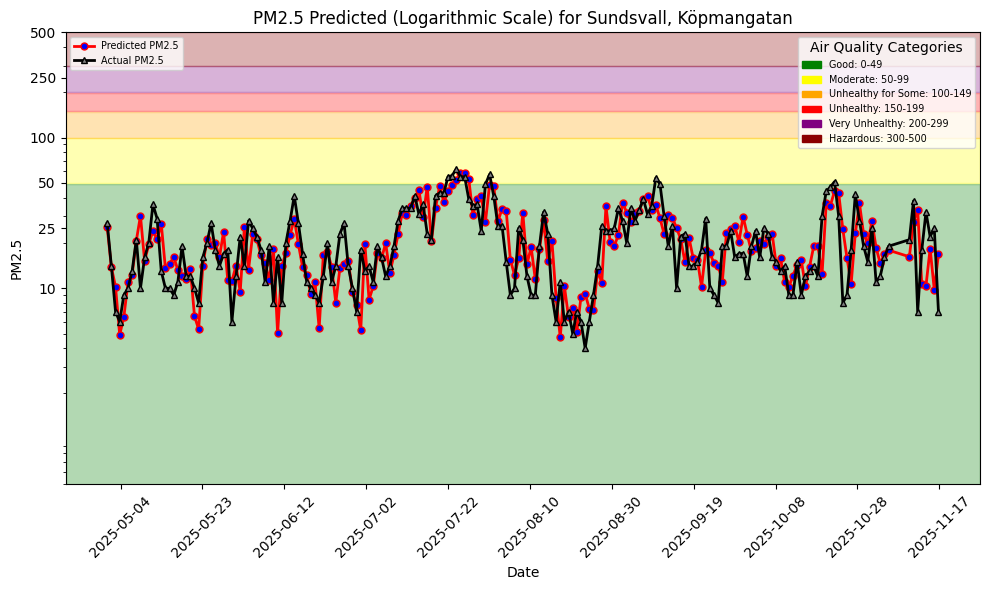

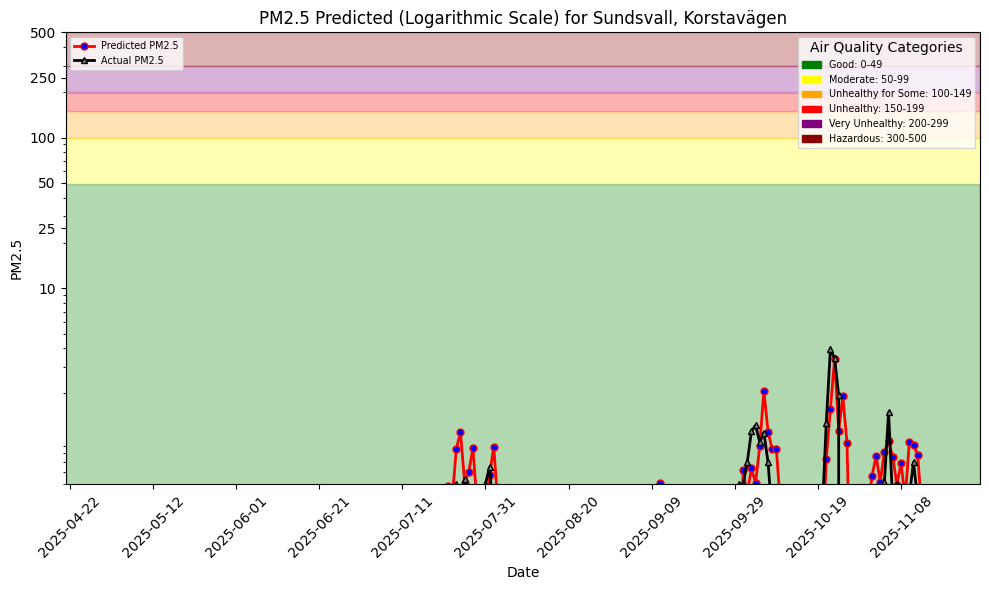

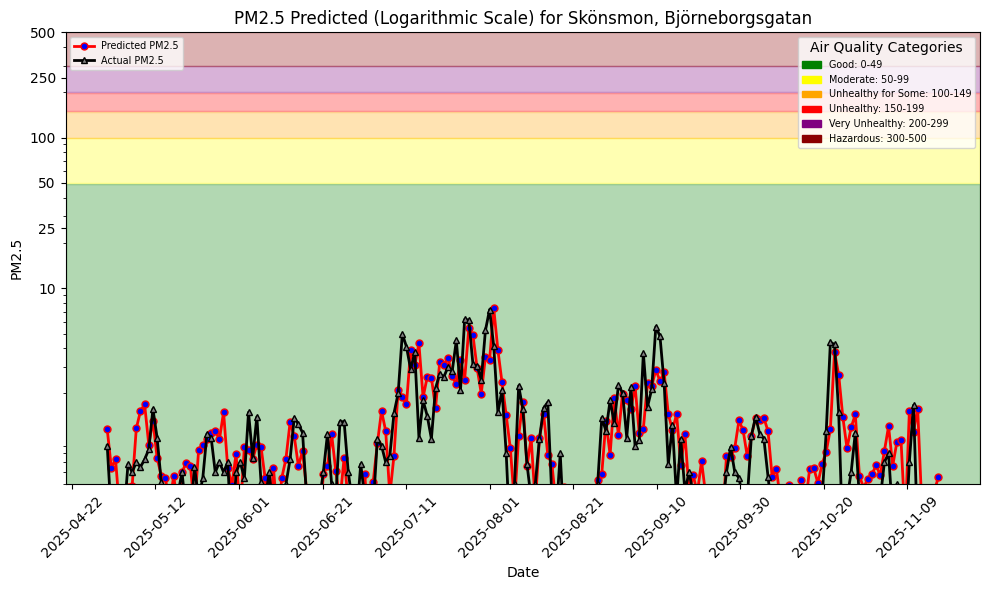

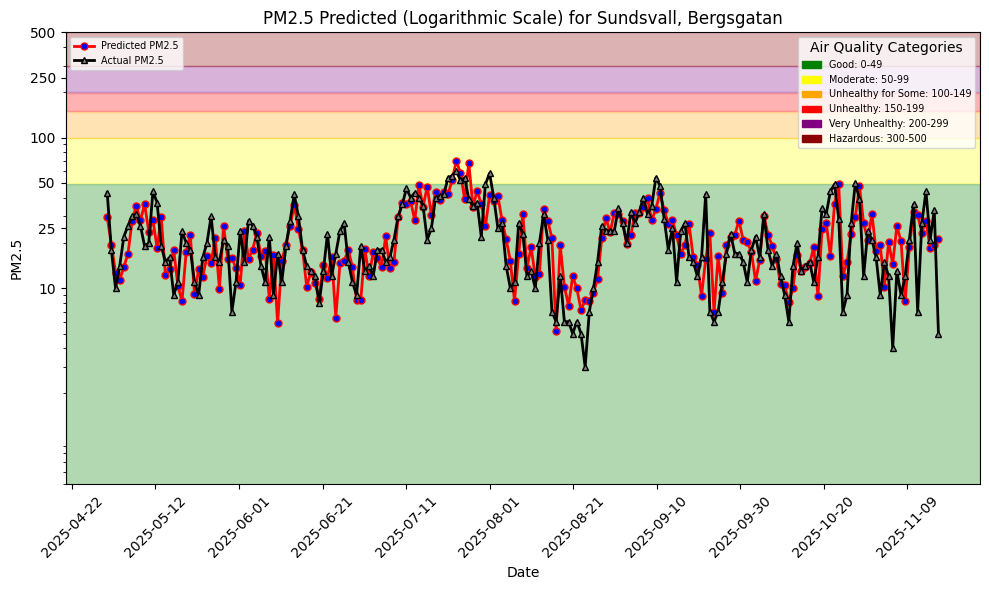

In [45]:
importlib.reload(util)
for key in index.keys():
    file_path = images_dir + f"/pm25_hindcast_{key}.png"
    plt = util.plot_air_quality_forecast(index[key]['city'], index[key]['street'], df[key], file_path, hindcast=True) 
    plt.show()

In [46]:
model.keys()

dict_keys(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5'])

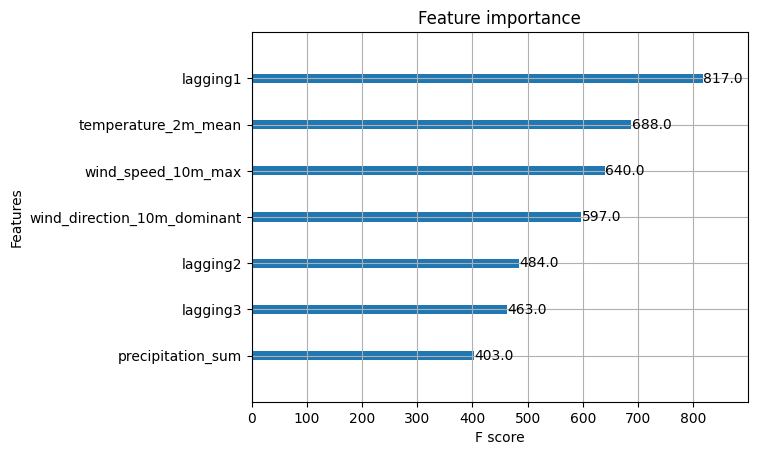

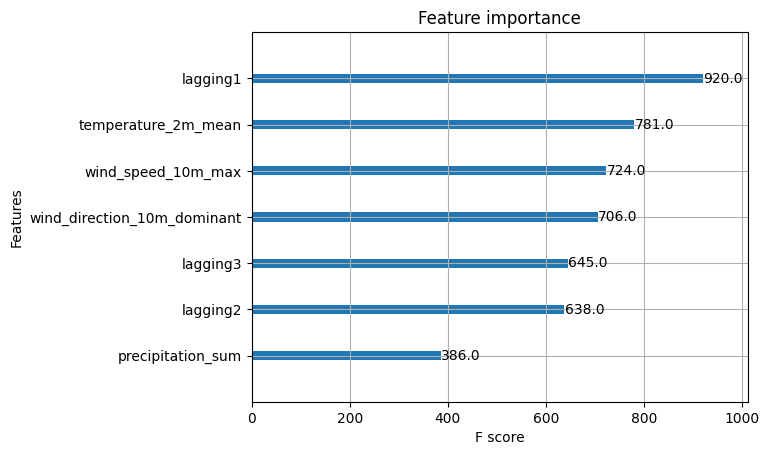

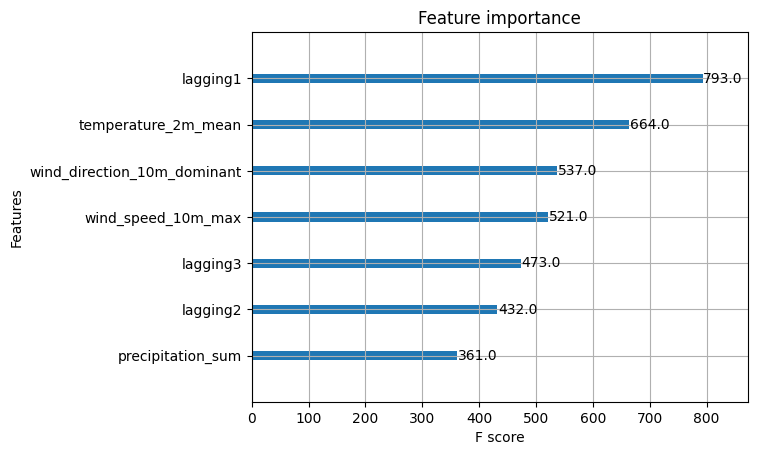

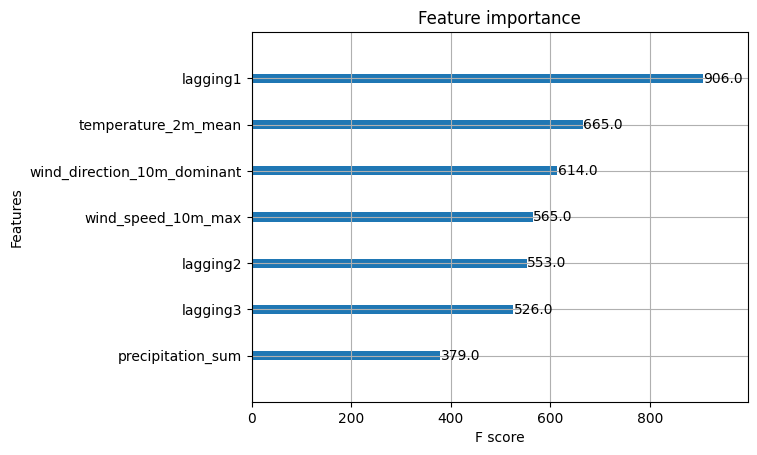

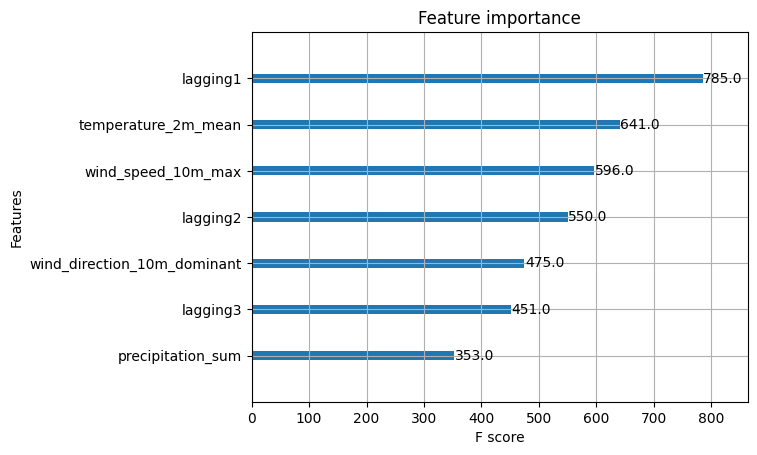

In [47]:
# Plotting feature importances using the plot_importance function from XGBoost
# sensor_4 has problems, so we exclude
for key in model.keys():
    plot_importance(model[key])
    feature_importance_path = images_dir + f"/feature_importance_{key}.png"
    plt.savefig(feature_importance_path)
    plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [48]:
model.keys()

dict_keys(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5'])

In [49]:
# Saving the XGBoost regressor object as a json file in the model directory
for key in model.keys():
    xgb_regressor = model[key]
    xgb_regressor.save_model(model_dir + f"/model_{key}.json")

In [50]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [51]:
model.keys()

dict_keys(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5'])

In [52]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

for key in model.keys():
    res_dict = { 
        "MSE": str( y_dict[key]['mse2']),
        "R squared": str( y_dict[key]['r2']),
    }
    aq_model = mr.python.create_model(
        name=f"air_quality_xgboost_model_a_{key}", 
        metrics= res_dict,
        feature_view=feature_view,
        description="Air Quality (PM2.5) predictor",
    )
    
    # Saving the model artifacts to the 'air_quality_model' directory in the model registry
    aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\model_schema.json: 0.000%|    …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286306/models/air_quality_xgboost_model_a_sensor_1/1


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\model_schema.json: 0.000%|    …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286306/models/air_quality_xgboost_model_a_sensor_2/1


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\model_schema.json: 0.000%|    …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286306/models/air_quality_xgboost_model_a_sensor_3/1


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\model_schema.json: 0.000%|    …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286306/models/air_quality_xgboost_model_a_sensor_4/1


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model/model_sensor…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/featu…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\air_quality_model\images/pm25_…

Uploading D:\ID2223 Scalable Machine Learning\Lab 1\mlfs_a\notebooks\airquality\model_schema.json: 0.000%|    …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286306/models/air_quality_xgboost_model_a_sensor_5/1


---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
